In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from pycaret.regression import *
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import src.paychex_ml.data_loader as dl
import src.paychex_ml.models as models

warnings.filterwarnings("ignore")

In [2]:
proyect_path = "C:/Users/bruno.gonzalez/DataspellProjects/Paychex_revenue_forecast"

In [3]:
# ------------------------------------------------------------------------------------- #
# This is where we change parameters to the model
# ------------------------------------------------------------------------------------- #
train_start_dt = '20140601'
train_end_dt = '20200501'
test_start_dt = '20200601'
test_end_dt = '20210501'
pred_start_dt = '20210601'
pred_end_dt = '20220101'
ml_criteria = 'MAE'
forecast_window = 8
forecast_type = '2+10'

In [4]:
# ------------------------------------------------------------------------------------- #
# Total Payroll Section
# ------------------------------------------------------------------------------------- #
#target_col = 'Payroll blended products'
#has_drivers = True
#target_col = 'W-2 Revenue'
#has_drivers = False
#target_col = 'Delivery Revenue'
#has_drivers = False
#target_col = 'ASO Allocation'
#has_drivers = False
#target_col = 'Other Processing Revenue'
#has_drivers = False
#target_col = 'SurePayroll.'
#has_drivers = True
#target_col = 'Total international'
#has_drivers = False

# ------------------------------------------------------------------------------------- #
# Total 401K Section
# ------------------------------------------------------------------------------------- #
#target_col = '401K Fee Revenue'
#has_drivers = True
target_col = '401K Asset fee & BP Revenue'
has_drivers = True

In [5]:
ml_col = target_col+' - ML Predicted'
uts_col = target_col+' - UTS Predicted'
plan_col = target_col+' - Plan'
fcst_col = target_col+' - '+forecast_type+' Forecast'
fcst_cols = [ml_col,uts_col,plan_col,fcst_col]
has_actuals = True
#has_drivers = False

In [6]:
# Get the full data frame and combine with drivers
#all_df = dl.get_level_0_data(train_start_dt, pred_end_dt)

In [7]:
file_path = proyect_path+"/data/clean/table_predictable.csv"
all_df = dl.get_clean_data(train_start_dt, pred_end_dt, file_path)

In [8]:
drive_path = proyect_path+"/data/clean/table_drivers.csv"
#driv_df_ = pd.read_csv(file_path, dtype={'Period':str, 'Calendar Date': str})
#driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, file_path)

In [9]:
all_df = all_df[['Calendar Date', target_col]]
if has_drivers:
    driv_df = dl.get_clean_driver_data(train_start_dt, pred_end_dt, target_col, drive_path)
    #driv_df.drop(columns=['Scenario'], inplace=True)
    all_df = pd.merge(all_df, driv_df, on='Calendar Date', how='inner')

In [14]:
external_path = proyect_path+"/data/external/external_data_fred.csv"
ext_df = pd.read_csv(external_path, dtype={'date': str})\
    .rename(columns={'date': 'Calendar Date'})
#ext_df = dl.get_external_data(train_start_dt, pred_end_dt)
all_df = pd.merge(all_df, ext_df, on='Calendar Date', how='inner')

In [15]:
# Train df
train_df = all_df[all_df['Calendar Date'].astype(int) <= int(train_end_dt)]
train_df['Calendar Date'] = pd.to_datetime(train_df['Calendar Date'])
print('Shape of the training dataframe:')
print(train_df.shape)

# Test df
test_df = all_df[(all_df['Calendar Date'].astype(int) >= int(test_start_dt)) & (all_df['Calendar Date'].astype(int) <= int(test_end_dt))]
test_df['Calendar Date'] = pd.to_datetime(test_df['Calendar Date'])
print('Shape of the testing dataframe:')
print(test_df.shape)

# Combined dataframe
comb_df = pd.concat([train_df, test_df])
print('Shape of the combination dataframe:')
print(comb_df.shape)

Shape of the training dataframe:
(72, 203)
Shape of the testing dataframe:
(12, 203)
Shape of the combination dataframe:
(84, 203)


                                                    401K Asset fee & BP Revenue
401K Asset fee & BP Revenue                                            1.000000
401(K) PLANS/5010 NATIONAL SALES/Sales - RW                            0.223461
401(K) PLANS/5020 EPlan Sales/Sales - RW                               0.624849
401(K) PLANS/5600 401K ADMINISTRATION/Average A...                     0.875888
401(K) PLANS/5600 401K ADMINISTRATION/Average A...                     0.636526
401(K) PLANS/5600 401K ADMINISTRATION/Basis Poi...                          NaN
401(K) PLANS/5600 401K ADMINISTRATION/Basis Pts...                          NaN
401(K) PLANS/5600 401K ADMINISTRATION/Ending As...                     0.958530
401(K) PLANS/5600 401K ADMINISTRATION/Ending Cl...                     0.925306
401(K) PLANS/5600 401K ADMINISTRATION/Loss % of...                     0.176183
401(K) PLANS/5600 401K ADMINISTRATION/Losses - RW                     -0.100472
401(K) PLANS/5600 401K ADMINISTRATION/Ma

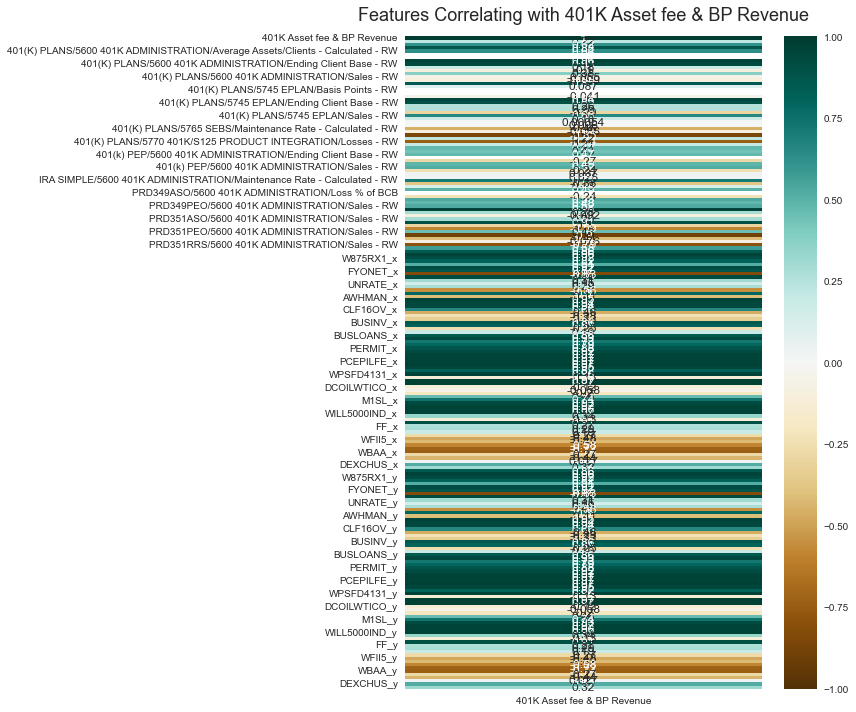

In [16]:
feature_cols = comb_df.columns.to_list()
feature_cols.remove('Calendar Date')
feature_cols.remove(target_col)

# Run Correlations to target
corr_df = comb_df.corr()[[target_col]]
print(corr_df)
#corr_df = corr_df[corr_df[target_col].abs() >= 0.75]
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(corr_df, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with '+target_col, fontdict={'fontsize':18}, pad=16);

In [17]:
# run auto ml and get the most important features
best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,439757.4076,335596185059.2568,578197.2889,-0.8624,0.0913,0.0730,0.0100
huber,Huber Regressor,441359.9985,354436252929.2152,594392.5715,-0.8958,0.0956,0.0718,0.0167
br,Bayesian Ridge,471293.0821,435144094334.9377,655038.9232,-1.4599,0.1126,0.0789,0.0100
dt,Decision Tree Regressor,560573.9259,441030850627.6296,660344.4065,-1.5100,0.1117,0.0903,0.0100
lr,Linear Regression,574141.0938,3322560206165.3335,1318471.2188,-11.5626,0.1325,0.0872,2.1000
gbr,Gradient Boosting Regressor,603599.6905,538076856639.2649,731745.3874,-2.0059,0.1242,0.0971,0.0433
xgboost,Extreme Gradient Boosting,654730.6875,643714886314.6666,800220.2292,-2.2970,0.1343,0.1030,0.1300
et,Extra Trees Regressor,697907.1961,715949120588.3730,836373.8514,-2.5287,0.1397,0.1089,0.1233
rf,Random Forest Regressor,734850.2406,783570818623.0800,874708.6171,-2.9144,0.1475,0.1150,0.1500
ada,AdaBoost Regressor,737296.4229,779158060324.9745,872801.8806,-2.9481,0.1481,0.1164,0.0533


<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'>


In [18]:
features = pd.DataFrame()
try:
    #features = models.get_important_features(get_config, best)
    feature_cols = features['Feature'].tolist()
except:
    #best_tree = compare_models(include=['br'], sort = ml_criteria)
    #features = get_important_features(get_config, best_tree)
    print('No default features available - will use the highest correlated columns')
    corr_df = corr_df.reset_index()
    feature_cols = corr_df['index'].tolist()
    feature_cols.remove(target_col)

# corr_df = corr_df.reset_index()
# feature_cols = corr_df['index'].tolist()
# feature_cols.remove(target_col)

# Feature Importance Plot - This is the out of box pycaret plot
#plot_model(best, plot = 'feature')

if len(features.index) != 0:
    # plot the most important features
    fig = px.bar(features.sort_values('Variable Importance', ascending=True),
                 x='Variable Importance',
                 y='Feature',
                 orientation='h',
                 title='Feature Importance Plot')
    fig.show()

No default features available - will use the highest correlated columns


In [19]:
# ------------------------------------------------------------------------------------- #
# re-run the auto ml with only the important features
# ------------------------------------------------------------------------------------- #
keeps = ['Calendar Date', target_col]+feature_cols
train_df = train_df[keeps]
test_df = test_df[keeps]
comb_df = comb_df[keeps]

best = models.run_auto_ml(train_df, test_df, target_col, feature_cols, False, ml_criteria)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
par,Passive Aggressive Regressor,439757.4076,335596185059.2568,578197.2889,-0.8624,0.0913,0.0730,0.0133
huber,Huber Regressor,441359.9985,354436252929.2152,594392.5715,-0.8958,0.0956,0.0718,0.0167
br,Bayesian Ridge,471293.0821,435144094334.9377,655038.9232,-1.4599,0.1126,0.0789,0.0133
dt,Decision Tree Regressor,560573.9259,441030850627.6296,660344.4065,-1.5100,0.1117,0.0903,0.0100
lr,Linear Regression,574141.0938,3322560206165.3335,1318471.2188,-11.5626,0.1325,0.0872,0.0100
gbr,Gradient Boosting Regressor,603599.6905,538076856639.2649,731745.3874,-2.0059,0.1242,0.0971,0.0333
xgboost,Extreme Gradient Boosting,654730.6875,643714886314.6666,800220.2292,-2.2970,0.1343,0.1030,0.1333
et,Extra Trees Regressor,697907.1961,715949120588.3730,836373.8514,-2.5287,0.1397,0.1089,0.0833
rf,Random Forest Regressor,734850.2406,783570818623.0800,874708.6171,-2.9144,0.1475,0.1150,0.0867
ada,AdaBoost Regressor,737296.4229,779158060324.9745,872801.8806,-2.9481,0.1481,0.1164,0.0433


<class 'sklearn.linear_model._passive_aggressive.PassiveAggressiveRegressor'>


In [22]:
# ------------------------------------------------------------------------------------- #
# generate and plot predicted values on the original dataset
# ------------------------------------------------------------------------------------- #

predictions = predict_model(best, data=comb_df)
predictions['Date'] = pd.date_range(start=str(train_start_dt), end = str(test_end_dt), freq = 'MS')
predictions.rename(columns={'Label':target_col+' - ML Predicted'}, inplace=True)
fig = px.line(predictions, x='Date', y=[target_col, target_col+' - ML Predicted'], template = 'plotly_white')
fig.show()

# ------------------------------------------------------------------------------------- #
# This section now applies the trained/tested model to make future predictions
# ------------------------------------------------------------------------------------- #

In [23]:
# create the future predictions dataframe
if has_actuals:
    act_df = all_df[all_df['Calendar Date'].astype(int) >= int(pred_start_dt)]
    act_df = act_df[keeps]
    act_df['Calendar Date'] = pd.to_datetime(act_df['Calendar Date'])
    pred_df = models.run_auto_arima(comb_df, feature_cols, pred_start_dt, forecast_window)
    final_best = finalize_model(best)
    #future_dates = pd.date_range(start = pred_start_dt, end = pred_end_dt, freq = 'MS')
    pred_df = predict_model(final_best, data=pred_df)
    #pred_df = pred_df[['Calendar Date', 'Label']]
    pred_df.rename(columns={'Label':ml_col}, inplace=True)
    concat_df = pd.merge(pred_df,act_df, on='Calendar Date', how='inner')
    
    # get plan data
    plan_df = dl.get_plan_data(pred_start_dt, pred_end_dt)
    plan_df = plan_df[['Calendar Date', target_col]]
    plan_df.rename(columns={target_col:plan_col}, inplace=True)
    plan_df['Calendar Date'] = pd.to_datetime(plan_df['Calendar Date'])
    concat_df = pd.merge(concat_df,plan_df, on='Calendar Date', how='inner')
    
    # get forecast data
    fcst_df = dl.get_forecast_data(pred_start_dt, pred_end_dt, forecast_type)
    fcst_df = fcst_df[['Calendar Date', target_col]]
    fcst_df.rename(columns={target_col:fcst_col}, inplace=True)
    fcst_df['Calendar Date'] = pd.to_datetime(fcst_df['Calendar Date'])
    concat_df = pd.merge(concat_df,fcst_df, on='Calendar Date', how='inner')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.84 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=992.039, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=960.394, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=946.108, Time=0.56 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=965.830, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=948.089, Time=0.45 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=inf, Time=1.13 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=948.550, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=974.171, Time=0.13 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=inf, Time=0.91 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=960.004, Time=0.27 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=inf, Time=0.69 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=947.732, Time=0.46 sec

Best model:  ARIMA(0,1,1)(0,1,1)[12]          
Total

In [24]:
# run UTS
uts_df = comb_df[['Calendar Date', target_col]]
uts_df = models.run_auto_arima(uts_df, [target_col], pred_start_dt, forecast_window)
uts_df.rename(columns={target_col:uts_col}, inplace=True)
concat_df = pd.merge(concat_df,uts_df, on='Calendar Date', how='inner')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2075.552, Time=0.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2097.714, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=2088.080, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2073.677, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2090.616, Time=0.05 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2072.184, Time=0.23 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2085.412, Time=0.11 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2069.700, Time=0.76 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2075.182, Time=0.30 sec
 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2070.860, Time=0.97 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2071.676, Time=0.55 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=2075.761, Time=0.31 sec
 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2071.680, Time=0.75 sec
 ARIMA(0,1,2)(2,1,1)[12]             : AIC=2071.581, Time=0.49 sec
 ARIMA(1,1,0)(2,1,1

In [25]:
# combine all data together
concat_df = pd.concat([comb_df,concat_df], axis=0)

# show plot
fig = px.line(concat_df, x='Calendar Date', y=[target_col, ml_col, uts_col, plan_col, fcst_col], template='plotly_white')
fig.show()

In [29]:
predictions_path = proyect_path+"/data/mapes_file/predictions.csv"
concat_df.to_csv(predictions_path)

In [32]:
# compute mape_df
mape_df = concat_df[['Calendar Date', target_col, ml_col, uts_col, plan_col, fcst_col]]
mape_df = mape_df[mape_df['Calendar Date'] >= datetime.strptime(pred_start_dt, '%Y%m%d')]
mape_df = models.compute_apes_and_mapes(mape_df, 'Calendar Date', target_col, fcst_cols)
mape_df.rename(index={True:'MAPE'}, inplace=True)
#print(mape_df)

mapes_file = proyect_path + '/data/predictions/mapes.xlsx'
mape_df.to_excel(mapes_file, sheet_name=target_col[0:31])